In [ ]:
# ===== Step 0: Install and Import Required Libraries =====
# ===== ステップ0: 必要なライブラリのインストールとインポート =====
!pip install emcee corner tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from astropy.coordinates import SkyCoord
from astropy import units as u
import emcee
import corner
from tqdm import tqdm
import os

# 日本語フォント設定
!apt-get -y install fonts-noto-cjk -qq
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# ===== Step 1: Preparation of SNe Data (No Changes) =====
# ===== ステップ1: SNeデータの準備 (変更なし) =====
sne_data_file = '/content/Pantheon+SH0ES.dat'
sne_cov_file = '/content/Pantheon+SH0ES_STAT+SYS.cov'
pantheon_data = pd.read_csv(sne_data_file, sep='\\s+', comment='#')
N_sne = len(pantheon_data)
cov_matrix_flat = np.loadtxt(sne_cov_file, skiprows=1)
cov_matrix = cov_matrix_flat.reshape((N_sne, N_sne))
print("共分散行列の逆行列を計算中...")
C_inv = np.linalg.inv(cov_matrix)
print("計算完了。")
l_d = 264.02 * u.deg
b_d = 48.25 * u.deg
d_coord_galactic = SkyCoord(l=l_d, b=b_d, frame='galactic')
d_vector = d_coord_galactic.cartesian.xyz.value
sn_coords_icrs = SkyCoord(ra=pantheon_data['RA'], dec=pantheon_data['DEC'], unit='deg', frame='icrs')
sn_coords_galactic = sn_coords_icrs.galactic
n_vectors_sn = sn_coords_galactic.cartesian.xyz.value.T
pantheon_data['cos_theta'] = np.dot(n_vectors_sn, d_vector)


# ===== Step 2: Definition of Final Model and Likelihood Function =====
# ===== ステップ2: 最終モデルと尤度関数の定義 =====
c_kms = 299792.458
f_baryon = 0.156
f_cdm = 1.0 - f_baryon

def p2(ct): return 0.5 * (3 * ct**2 - 1)
def r_iso_transition_model(a, R_early, R_late, a_trans, delta_a):
    return R_late + (R_early - R_late) * 0.5 * (1 - np.tanh((a - a_trans) / delta_a))

def hubble_parameter_interaction(z, cos_theta, H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0):
    a = 1.0 / (1.0 + z)
    Omega_rad = 9.24e-5
    Omega_L = 1.0 - Omega_m - Omega_rad
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

# ★★★ ここを修正 ★★★
# get_mu_theory_loop は、8つの宇宙論パラメータを直接受け取るように修正
def get_mu_theory_loop(cosmo_params, data):
    # cosmo_paramsは既に8つのパラメータなので、ここでのスライスは不要
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0 = cosmo_params
    z_obs = data['zCMB'].values
    cos_theta_obs = data['cos_theta'].values
    mu_th_array = np.zeros_like(z_obs)
    for i in range(len(z_obs)):
        integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, cos_theta_obs[i], *cosmo_params)
        chi, _ = quad(integrand, 0, z_obs[i])
        DL = c_kms * (1 + z_obs[i]) * chi
        mu_th_array[i] = 5 * np.log10(DL) + 25 if DL > 0 else np.inf
    return mu_th_array

def log_likelihood_sne_with_cov(params, data, C_inv):
    M = params[-1]
    cosmo_params = params[:-1]
    mu_obs = data['m_b_corr'].values
    mu_th_model = get_mu_theory_loop(cosmo_params, data)
    if np.any(np.isinf(mu_th_model)): return -np.inf
    diff = mu_obs - (mu_th_model + M)
    chi2_sne = diff @ C_inv @ diff
    return -0.5 * chi2_sne

def log_prior(params):
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0, M = params
    if 60.0 < H0 < 80.0 and 0.1 < Omega_m < 0.5 and \
       0.0 < A2 < 1.0 and 0.0 < R_early < 2.0 and \
       0.5 < R_late < 1.5 and 0.1 < a_trans < 0.9 and \
       0.01 < delta_a < 0.5 and 0.0 < Gamma0 < 0.1 and \
       -20.0 < M < -18.0:
        return 0.0
    return -np.inf

def log_probability_sne_only(params, data_sne, C_inv_sne):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_sne_with_cov(params, data_sne, C_inv_sne)


# ===== Step 3: Run MCMC (with Pause and Resume Functionality) =====
# ===== ステップ3: MCMCの実行 (中断・再開機能付き) =====
ndim = 9
nwalkers = 32
data_sne_to_use = pantheon_data
C_inv_to_use = C_inv
total_nsteps = 10000
burn_in = 2000
filename = "sne_interaction_model_backend.h5"

if os.path.exists(filename):
    print("以前の実行ファイルが見つかりました。計算を再開します。")
    backend = emcee.backends.HDFBackend(filename, read_only=False)
    initial_state = backend.get_last_sample()
    n_steps_done = backend.iteration
    print(f"完了済みステップ数: {n_steps_done}")
else:
    print("新しいMCMC実行を開始します。")
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    initial_params = np.array([70.0, 0.3, 0.1, 1.0, 1.0, 0.5, 0.1, 0.01, -19.3])
    initial_state = initial_params + 1e-3 * np.random.randn(nwalkers, ndim)
    n_steps_done = 0

steps_to_run = total_nsteps - n_steps_done
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_sne_only,
                                args=(data_sne_to_use, C_inv_to_use),
                                backend=backend)

if steps_to_run > 0:
    print(f"残り {steps_to_run} ステップのMCMCサンプリングを実行します...")
    sampler.run_mcmc(initial_state, steps_to_run, progress=True)
    print("MCMCサンプリングが完了しました。")
else:
    print("計算は既に完了しています。")


# ===== Step 4: Visualization of Results =====
# ===== ステップ4: 結果の可視化 =====
flat_samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)
labels = [r"$H_0$", r"$\Omega_m$", r"$A_2$", r"$R_{early}$", r"$R_{late}$", r"$a_{trans}$", r"$\Delta a$", r"$\Gamma_0$", r"$M$"]
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

print("\n--- パラメータ推定結果 (SNe単独, 最終モデル, 本番実行) ---")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.4f} +{q[1]:.4f} -{q[0]:.4f}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm import tqdm

# 日本語フォント設定
!apt-get -y install fonts-noto-cjk -qq
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# ===== Step 1: Model Definition and Preparation of Observational Data =====
# ===== ステップ1: モデル定義と観測データの準備 =====
c_kms = 299792.458
f_baryon = 0.156
f_cdm = 1.0 - f_baryon

def p2(ct): return 0.5 * (3 * ct**2 - 1)
def r_iso_transition_model(a, R_early, R_late, a_trans, delta_a):
    return R_late + (R_early - R_late) * 0.5 * (1 - np.tanh((a - a_trans) / delta_a))

def hubble_parameter_interaction(z, cos_theta, H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0):
    a = 1.0 / (1.0 + z)
    Omega_rad = 9.24e-5
    Omega_L = 1.0 - Omega_m - Omega_rad
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

# --- Loading Observational Data ---
# --- 観測データの読み込み ---
sne_data_file = '/content/Pantheon+SH0ES.dat'
pantheon_data = pd.read_csv(sne_data_file, sep='\\s+', comment='#')
# All Data Points Will Be Used for Plotting
# プロットするデータは全点を使用
pantheon_plot_data = pantheon_data.reset_index(drop=True)


# ===== Step 2: ★Set Final Parameters Obtained from Production Run★ =====
# ===== ステップ2: ★本番実行で得られた最終パラメータを設定★ =====
best_fit_params = {
    "H0": 70.8049,
    "Omega_m": 0.3871,
    "A2": 0.2966,
    "R_early": 0.6074,
    "R_late": 0.8998,
    "a_trans": 0.5853,
    "delta_a": 0.2577,
    "Gamma0": 0.0405,
    "M": -19.2987
}
cosmo_params_tuple = (best_fit_params["H0"], best_fit_params["Omega_m"], best_fit_params["A2"],
                      best_fit_params["R_early"], best_fit_params["R_late"], best_fit_params["a_trans"],
                      best_fit_params["delta_a"], best_fit_params["Gamma0"])
M_fit = best_fit_params["M"]


# ===== Step 3: Calculation of Theoretical Curve =====
# ===== ステップ3: 理論曲線の計算 =====
z_theory = np.linspace(0.01, 2.3, 200)

def get_mu_theory_for_curve(z_array, cos_theta, params):
    mu_th_array = np.zeros_like(z_array)
    for i, z in enumerate(tqdm(z_array, desc=f"Calculating curve for cos(theta)={cos_theta:.1f}")):
        integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, cos_theta, *params)
        chi, _ = quad(integrand, 0, z)
        DL = c_kms * (1 + z) * chi
        mu_th_array[i] = 5 * np.log10(DL) + 25 if DL > 0 else np.inf
    return mu_th_array

print("理論曲線の計算を開始します...")
mu_theory_axis = get_mu_theory_for_curve(z_theory, 1.0, cosmo_params_tuple)
mu_theory_equator = get_mu_theory_for_curve(z_theory, 0.0, cosmo_params_tuple)

# --- Calculation of Theoretical Values for Residual Plot ---
# --- 残差プロット用の理論値計算 ---
l_d = 264.02 * u.deg
b_d = 48.25 * u.deg
d_coord_galactic = SkyCoord(l=l_d, b=b_d, frame='galactic')
d_vector = d_coord_galactic.cartesian.xyz.value
sn_coords_icrs = SkyCoord(ra=pantheon_plot_data['RA'], dec=pantheon_plot_data['DEC'], unit='deg', frame='icrs')
sn_coords_galactic = sn_coords_icrs.galactic
n_vectors_sn = sn_coords_galactic.cartesian.xyz.value.T
pantheon_plot_data['cos_theta'] = np.dot(n_vectors_sn, d_vector)

mu_theory_at_data_points = np.zeros(len(pantheon_plot_data))
print("\n残差プロット用の理論値を計算中...")
for i, row in tqdm(pantheon_plot_data.iterrows(), total=len(pantheon_plot_data)):
    integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, row['cos_theta'], *cosmo_params_tuple)
    chi, _ = quad(integrand, 0, row['zCMB'])
    DL = c_kms * (1 + row['zCMB']) * chi
    mu_th_model_only = 5 * np.log10(DL) + 25 if DL > 0 else np.inf
    mu_theory_at_data_points[i] = mu_th_model_only + M_fit


# ===== Step 4: Plotting the Graph =====
# ===== ステップ4: グラフの描画 =====
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
title_params = f'$H_0={best_fit_params["H0"]:.2f}, \\Omega_m={best_fit_params["Omega_m"]:.2f}, A_2={best_fit_params["A2"]:.2f}, \\Gamma_0={best_fit_params["Gamma0"]:.2f}, M={best_fit_params["M"]:.2f}$'
fig.suptitle(f"DIRT相互作用モデルの最適フィットと観測データの比較（最終結果）\n({title_params})", fontsize=16, fontproperties=font_prop)

# Observational Data Points
# 観測データ点
ax1.errorbar(pantheon_plot_data['zCMB'], pantheon_plot_data['m_b_corr'],
             yerr=pantheon_plot_data['m_b_corr_err_DIAG'],
             fmt='o', color='gray', alpha=0.4, label='Pantheon+ データ点', markersize=3, zorder=2)

# Theoretical Curve
# 理論曲線
ax1.plot(z_theory, mu_theory_axis + M_fit, color='red', linestyle='-', label=r'DIRTモデル理論値（軸方向, $\cos\theta=1$）', zorder=3)
ax1.plot(z_theory, mu_theory_equator + M_fit, color='blue', linestyle='--', label=r'DIRTモデル理論値（赤道方向, $\cos\theta=0$）', zorder=3)

ax1.set_ylabel("見かけの距離指数 $\\mu$ (等級)", fontproperties=font_prop)
ax1.legend(prop=font_prop)
ax1.grid(True)
ax1.invert_yaxis()

# Residual Plot
# 残差プロット
residuals = pantheon_plot_data['m_b_corr'] - mu_theory_at_data_points
ax2.errorbar(pantheon_plot_data['zCMB'], residuals,
             yerr=pantheon_plot_data['m_b_corr_err_DIAG'],
             fmt='o', color='black', markersize=3, alpha=0.5)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel("赤方偏移 z", fontproperties=font_prop)
ax2.set_ylabel("残差 (等級)", fontproperties=font_prop)
ax2.grid(True)
ax2.set_ylim(-2, 2)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [2]:
# ===== Step 0: Install and Import Required Libraries =====
# ===== ステップ0: 必要なライブラリのインストールとインポート =====
!pip install emcee corner tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00


Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
SNe共分散行列の逆行列を計算中...
計算完了。
以前の実行ファイルが見つかりました。計算を再開します。
完了済みステップ数: 8658
残り 1342 ステップのMCMCサンプリングを実行します...


100%|██████████| 1342/1342 [2:44:51<00:00,  7.37s/it]


MCMCサンプリングが完了しました。


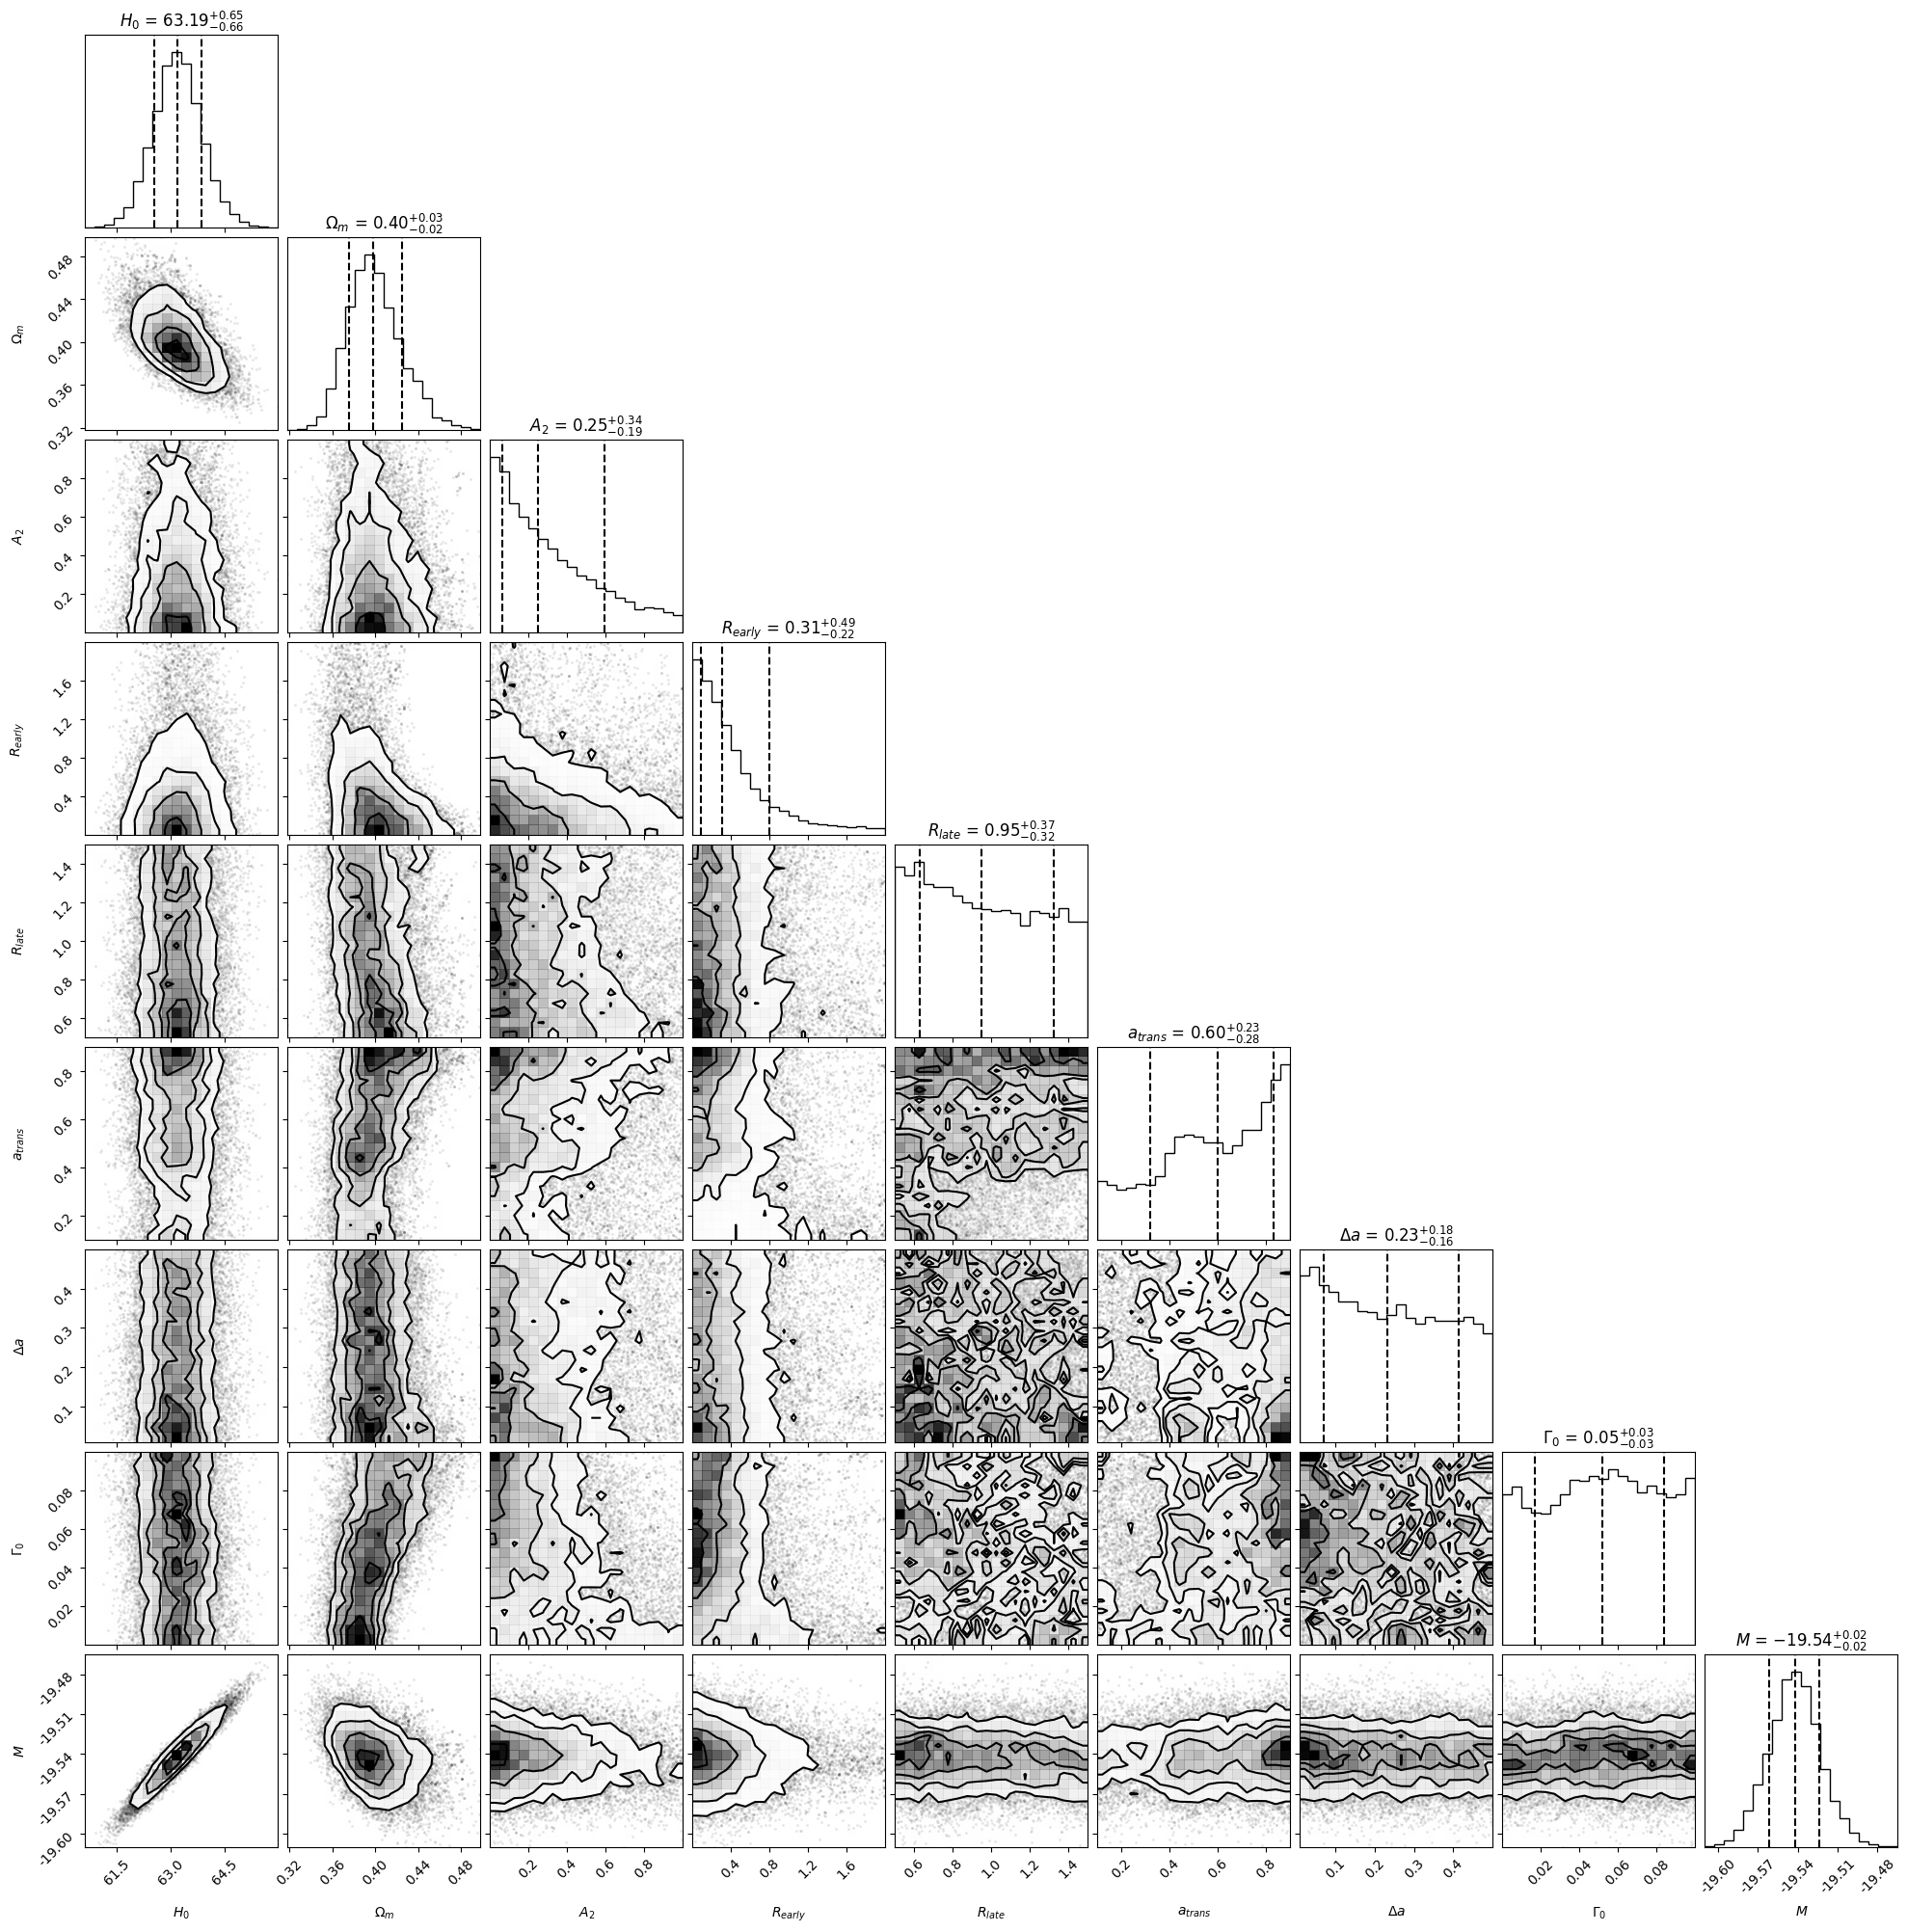


--- パラメータ推定結果 (SNe+BAO 統合解析) ---
$H_0$ = 63.1918 +0.6535 -0.6560
$\Omega_m$ = 0.3977 +0.0272 -0.0220
$A_2$ = 0.2494 +0.3447 -0.1866
$R_{early}$ = 0.3100 +0.4890 -0.2243
$R_{late}$ = 0.9465 +0.3745 -0.3174
$a_{trans}$ = 0.5974 +0.2325 -0.2771
$\Delta a$ = 0.2332 +0.1792 -0.1618
$\Gamma_0$ = 0.0516 +0.0323 -0.0347
$M$ = -19.5422 +0.0187 -0.0195


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from astropy.coordinates import SkyCoord
from astropy import units as u
import emcee
import corner
from tqdm import tqdm
import os

# Japanese Font Settings
# 日本語フォント設定
!apt-get -y install fonts-noto-cjk -qq
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# ===== Step 1: Preparation of All Data =====
# Preparation of SNe Data
# ===== ステップ1: 全データの準備 =====
# SNe データの準備
sne_data_file = '/content/Pantheon+SH0ES.dat'
sne_cov_file = '/content/Pantheon+SH0ES_STAT+SYS.cov'
pantheon_data = pd.read_csv(sne_data_file, sep='\\s+', comment='#')
N_sne = len(pantheon_data)
cov_matrix_flat = np.loadtxt(sne_cov_file, skiprows=1)
cov_matrix = cov_matrix_flat.reshape((N_sne, N_sne))
print("SNe共分散行列の逆行列を計算中...")
C_inv_sne = np.linalg.inv(cov_matrix)
print("計算完了。")
l_d = 264.02 * u.deg
b_d = 48.25 * u.deg
d_coord_galactic = SkyCoord(l=l_d, b=b_d, frame='galactic')
d_vector = d_coord_galactic.cartesian.xyz.value
sn_coords_icrs = SkyCoord(ra=pantheon_data['RA'], dec=pantheon_data['DEC'], unit='deg', frame='icrs')
sn_coords_galactic = sn_coords_icrs.galactic
n_vectors_sn = sn_coords_galactic.cartesian.xyz.value.T
pantheon_data['cos_theta'] = np.dot(n_vectors_sn, d_vector)

# Preparation of BAO Data
# BAO データの準備
bao_data_list = [
    [0.70, 'DH', 180.0, 15.0, 19.33, 0.57], [0.70, 'DM', 180.0, 15.0, 17.86, 0.33],
    [1.48, 'DH', 195.0, 25.0, 13.23, 0.47], [1.48, 'DM', 195.0, 25.0, 30.21, 0.79],
    [0.50, 'DH', 190.0, 40.0, 23.39, 0.70], [0.50, 'DM', 190.0, 40.0, 14.05, 0.17],
    [0.90, 'DH', 210.0, 35.0, 17.58, 0.38], [0.90, 'DM', 210.0, 35.0, 22.01, 0.24],
    [1.60, 'DH', 170.0, 10.0, 12.39, 0.31], [1.60, 'DM', 170.0, 10.0, 32.11, 0.59]
]
bao_df = pd.DataFrame(bao_data_list, columns=['z', 'type', 'RA', 'DEC', 'value', 'error'])
bao_coords_icrs = SkyCoord(ra=bao_df['RA'], dec=bao_df['DEC'], unit='deg', frame='icrs')
bao_coords_galactic = bao_coords_icrs.galactic
n_vectors_bao = bao_coords_galactic.cartesian.xyz.value.T
bao_df['cos_theta'] = np.dot(n_vectors_bao, d_vector)

# ===== Step 2: Definition of Model and Likelihood Function =====
# ===== ステップ2: モデルと尤度関数の定義 =====
c_kms = 299792.458
r_d_fiducial = 147.09
f_baryon = 0.156
f_cdm = 1.0 - f_baryon

def p2(ct): return 0.5 * (3 * ct**2 - 1)
def r_iso_transition_model(a, R_early, R_late, a_trans, delta_a):
    return R_late + (R_early - R_late) * 0.5 * (1 - np.tanh((a - a_trans) / delta_a))
def hubble_parameter_interaction(z, cos_theta, H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0):
    a = 1.0 / (1.0 + z)
    Omega_rad = 9.24e-5
    Omega_L = 1.0 - Omega_m - Omega_rad
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

def get_mu_theory_loop(cosmo_params, data):
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0 = cosmo_params
    z_obs, cos_theta_obs = data['zCMB'].values, data['cos_theta'].values
    mu_th_array = np.zeros_like(z_obs)
    for i in range(len(z_obs)):
        integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, cos_theta_obs[i], *cosmo_params)
        chi, _ = quad(integrand, 0, z_obs[i])
        DL = c_kms * (1 + z_obs[i]) * chi
        mu_th_array[i] = 5 * np.log10(DL) + 25 if DL > 0 else np.inf
    return mu_th_array

def log_likelihood_sne_with_cov(params, data, C_inv):
    M, cosmo_params = params[-1], params[:-1]
    mu_obs, mu_th_model = data['m_b_corr'].values, get_mu_theory_loop(cosmo_params, data)
    if np.any(np.isinf(mu_th_model)): return -np.inf
    diff = mu_obs - (mu_th_model + M)
    return -0.5 * (diff @ C_inv @ diff)

def log_likelihood_bao(params, data):
    cosmo_params = params[:-1]
    chi2_bao = 0
    for _, row in data.iterrows():
        z, type, ct, val, err = row['z'], row['type'], row['cos_theta'], row['value'], row['error']
        if type == 'DH':
            th = (c_kms / hubble_parameter_interaction(z, ct, *cosmo_params)) / r_d_fiducial
        elif type == 'DM':
            integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, ct, *cosmo_params)
            chi, _ = quad(integrand, 0, z)
            th = (c_kms * chi) / r_d_fiducial
        chi2_bao += ((val - th) / err)**2
    return -0.5 * chi2_bao

def log_prior(params):
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0, M = params
    if 60.0<H0<80.0 and 0.1<Omega_m<0.5 and 0.0<A2<1.0 and 0.0<R_early<2.0 and \
       0.5<R_late<1.5 and 0.1<a_trans<0.9 and 0.01<delta_a<0.5 and 0.0<Gamma0<0.1 and \
       -20.0<M<-18.0:
        return 0.0
    return -np.inf

def log_probability_joint(params, data_sne, C_inv_sne, data_bao):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll_sne = log_likelihood_sne_with_cov(params, data_sne, C_inv_sne)
    ll_bao = log_likelihood_bao(params, data_bao)
    return lp + ll_sne + ll_bao

# ===== Step 3: Run MCMC (with Pause and Resume Functionality) =====
# ===== ステップ3: MCMCの実行 (中断・再開機能付き) =====
ndim, nwalkers = 9, 32
total_nsteps, burn_in = 10000, 2000
filename = "joint_sne_bao_backend.h5"

if os.path.exists(filename):
    print("以前の実行ファイルが見つかりました。計算を再開します。")
    backend = emcee.backends.HDFBackend(filename, read_only=False)
    initial_state = backend.get_last_sample()
    n_steps_done = backend.iteration
    print(f"完了済みステップ数: {n_steps_done}")
else:
    print("新しいMCMC実行を開始します。")
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    # Set the optimal values from SNe-only analysis as initial values
    # SNe単独解析の最適値を初期値に設定
    initial_params = np.array([70.80, 0.39, 0.30, 0.61, 0.90, 0.59, 0.26, 0.04, -19.30])
    initial_state = initial_params + 1e-3 * np.random.randn(nwalkers, ndim)
    n_steps_done = 0

steps_to_run = total_nsteps - n_steps_done
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_joint,
                                args=(pantheon_data, C_inv_sne, bao_df),
                                backend=backend)

if steps_to_run > 0:
    print(f"残り {steps_to_run} ステップのMCMCサンプリングを実行します...")
    sampler.run_mcmc(initial_state, steps_to_run, progress=True)
    print("MCMCサンプリングが完了しました。")
else:
    print("計算は既に完了しています。")

# ===== Step 4: Visualization of Results =====
# ===== ステップ4: 結果の可視化 =====
flat_samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)
labels = [r"$H_0$", r"$\Omega_m$", r"$A_2$", r"$R_{early}$", r"$R_{late}$", r"$a_{trans}$", r"$\Delta a$", r"$\Gamma_0$", r"$M$"]
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

print("\n--- パラメータ推定結果 (SNe+BAO 統合解析) ---")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.4f} +{q[1]:.4f} -{q[0]:.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import solve_ivp
# ===== Step 1: Model Definition and Parameter Setting =====
# ===== ステップ1: モデル定義とパラメータ設定 =====

# — Physical Constants —
# --- 物理定数 ---
c_kms = 299792.458  # Speed of Light (km/s) # 光速 (km/s)
Omega_rad = 9.24e-5 # Radiation Density Parameter # 放射の密度パラメータ

# — Set the Best-Fit Values Obtained from SNe+BAO Joint Analysis —
# --- SNe+BAO統合解析で得られた最適値を設定 ---
H0 = 63.19
Omega_m = 0.40
A2 = 0.25
R_early = 0.31
R_late = 0.95
a_trans = 0.60
delta_a = 0.23
Gamma0 = 0.05

# — Core Function of the DIRT Interaction Model —
# --- DIRT相互作用モデルのコア関数 ---
def p2(cos_theta):
    """ルジャンドル多項式 P_2(x) を計算"""
    return 0.5 * (3 * cos_theta**2 - 1)

def r_iso_transition_model(a, R_early_val, R_late_val, a_trans_val, delta_a_val):
    """R_lockの等方的な相転移モデル部分を計算"""
    return R_late_val + (R_early_val - R_late_val) * 0.5 * (1 - np.tanh((a - a_trans_val) / delta_a_val))

def hubble_parameter_interaction(z, cos_theta=1.0):
    """
    DIRT相互作用モデルにおけるハッブルパラメータ H(z) を計算。
    cos_thetaは方向依存性を表すが、背景進化の計算では平均的な値(cos_theta=1 or 0)を使う。
    """
    a = 1.0 / (1.0 + z)
    Omega_L = 1.0 - Omega_m - Omega_rad

    # Compute DIRT Model-Specific Term
    # DIRTモデル固有の項を計算
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)

    # Combine Cosmological Terms
    # 宇宙論項を結合
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L

    if h2 < 0:
        return np.inf  # Physically Impossible Region # 物理的にありえない領域

    return H0 * np.sqrt(h2)

# — Operation Check —
# --- 動作確認 ---
z_test = 1.0
H_test = hubble_parameter_interaction(z_test)
print(f"テスト計算：z = {z_test} における H(z) = {H_test:.4f} km/s/Mpc")

z_test_aniso = 1.0
H_test_aniso = hubble_parameter_interaction(z_test_aniso, cos_theta=0.0) # Examine the Effect of Anisotropy # 異方性の効果を見る
print(f"テスト計算 (異方性)：z = {z_test_aniso}, cos_theta=0 における H(z) = {H_test_aniso:.4f} km/s/Mpc")

In [ ]:
# Japanese Font Settings
# 日本語フォント設定
!apt-get -y install fonts-noto-cjk -qq
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# ===== Step 2: Calculation of Matter Perturbation Growth (Revised Version) =====
# ===== ステップ2: 物質ゆらぎの成長計算 (修正版) =====
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from scipy.integrate import solve_ivp

# — Physical Constants and Model Parameters (Reposted) —
# --- 物理定数とモデルパラメータ（再掲） ---
c_kms = 299792.458
Omega_rad = 9.24e-5
H0 = 63.19
Omega_m = 0.40
A2 = 0.25
R_early = 0.31
R_late = 0.95
a_trans = 0.60
delta_a = 0.23
Gamma0 = 0.05

# — Core Function of the DIRT Model (Reposted) —
# --- DIRTモデルのコア関数（再掲） ---
def p2(cos_theta):
    return 0.5 * (3 * cos_theta**2 - 1)

def r_iso_transition_model(a, R_early_val, R_late_val, a_trans_val, delta_a_val):
    return R_late_val + (R_early_val - R_late_val) * 0.5 * (1 - np.tanh((a - a_trans_val) / delta_a_val))

def hubble_parameter_interaction(z, cos_theta=1.0):
    a = 1.0 / (1.0 + z)
    Omega_L = 1.0 - Omega_m - Omega_rad
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

# — Standard ΛCDM Model for Comparison (Reposted) —
# --- 比較用の標準ΛCDMモデル（再掲） ---
def hubble_parameter_lcdm(z, H0_lcdm=67.4, Omega_m_lcdm=0.315):
    a = 1.0 / (1.0 + z)
    Omega_L_lcdm = 1.0 - Omega_m_lcdm - Omega_rad
    h2 = (Omega_rad / a**4) + (Omega_m_lcdm / a**3) + Omega_L_lcdm
    return H0_lcdm * np.sqrt(h2)

# — Create a Table of Angle-Averaged H(z) Calculations —
# --- 角度平均したH(z)の計算テーブルを作成 ---
a_vals_for_H_table = np.logspace(-4, 0, 200)
H2_avg_table = np.array([quad(lambda ct: hubble_parameter_interaction(1.0/a - 1.0, ct)**2, 0, 1)[0] for a in a_vals_for_H_table])

def get_H_avg(a):
    return np.sqrt(np.interp(a, a_vals_for_H_table, H2_avg_table))

# — Define the Growth Equation of Perturbations —
# --- ゆらぎの成長方程式を定義 ---
def growth_ode(a, y, model_type='DIRT'):
    H_val = get_H_avg(a) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a - 1)

    # For simplicity, approximate the H’ term using numerical differences
    # 簡単のため、H'の項は数値差分で近似
    delta = 1e-6
    a_plus = a + delta
    a_minus = a - delta if a > delta else a/2.

    H_plus = get_H_avg(a_plus) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a_plus - 1)
    H_minus = get_H_avg(a_minus) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a_minus - 1)
    H_prime = (H_plus - H_minus) / (a_plus - a_minus)

    # Compute the Effective Omega_m(a)
    # 有効なOmega_m(a)の計算
    if model_type == 'DIRT':
        Omega_m_eff = (Omega_m/a**3) * (a**(3*Gamma0*(1-r_iso_transition_model(a,R_early,R_late,a_trans,delta_a))))
    else: # LCDM
        Omega_m_eff = 0.315 / a**3

    dD_da = y[1]
    d2D_da2 = -(3./a + H_prime / H_val) * y[1] + (1.5 * H0**2 * Omega_m_eff / (a**2 * H_val**2)) * y[0]

    return [dD_da, d2D_da2]

# — Solve the Differential Equation —
# --- 微分方程式を解く ---
a_init = 1e-3
a_span = [a_init, 1.0]
a_eval = np.logspace(np.log10(a_init), 0, 200)

# DIRT Model
# DIRTモデル
y_init = [a_init, 1.0]
sol_dirt = solve_ivp(lambda a, y: growth_ode(a, y, 'DIRT'), a_span, y_init, t_eval=a_eval, method='RK45')
D_a_dirt = sol_dirt.y[0] / sol_dirt.y[0][-1] # Normalize to D(a=1) = 1 # D(a=1)=1に規格化

# ΛCDM Model
# ΛCDMモデル
sol_lcdm = solve_ivp(lambda a, y: growth_ode(a, y, 'LCDM'), a_span, y_init, t_eval=a_eval, method='RK45')
D_a_lcdm = sol_lcdm.y[0] / sol_lcdm.y[0][-1] # Normalize to D(a=1) = 1 # D(a=1)=1に規格化

# — Plot the Results —
# --- 結果をプロット ---
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)

plt.figure(figsize=(10, 6))
plt.plot(sol_dirt.t, D_a_dirt, label='DIRTモデル (SNe+BAO fit)', lw=2.5)
plt.plot(sol_lcdm.t, D_a_lcdm, label='標準ΛCDMモデル (Planck 2018)', lw=2, linestyle='--')
plt.xscale('log')
plt.xlabel('スケールファクタ a', fontproperties=font_prop, fontsize=12)
plt.ylabel('規格化された成長因子 D(a)', fontproperties=font_prop, fontsize=12)
plt.title('DIRTモデルとΛCDMモデルにおける物質ゆらぎの成長史', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [ ]:
# ===== Step 3: Calculation and Comparison of the CMB Angular Power Spectrum C_\ell (Final Revised Version) =====
# ===== ステップ3: CMB角パワースペクトル Cl の計算と比較 (最終修正版) =====
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn

print("ステップ3を開始します：CMB角パワースペクトル計算（最終修正版）")

# — Font and Model Definition (Reposted) —
# --- フォントとモデル定義（再掲）---
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
# (Assumes that variables and functions defined in the first cell are available)
# (最初のセルで定義された変数・関数が利用可能であると仮定)

# — 1. Preparation of Fundamental Cosmological Parameters and Functions —
# --- 1. 基礎となる宇宙論パラメータと関数の準備 ---
A_s = 2.1e-9  # Amplitude of the Dimensionless Power Spectrum # 無次元パワースペクトルの振幅
n_s = 0.965   # Spectral Index # スペクトル指数
k0_ref = 0.05 # Reference Scale (Mpc⁻¹) # 参照スケール (Mpc^-1)

def P_zeta(k):
    """無次元プライモーディアル曲率パワースペクトル P_zeta(k)"""
    return A_s * (k / k0_ref)**(n_s - 1)

# — 2. Preparation of Interpolation Functions (Reposted) —
# --- 2. 補間関数の準備 (再掲) ---
D_interp = interp1d(sol_dirt.t, sol_dirt.y[0], kind='cubic', fill_value='extrapolate')
D_prime_interp = interp1d(sol_dirt.t, sol_dirt.y[1], kind='cubic', fill_value='extrapolate')
H_avg_interp = interp1d(a_vals_for_H_table, np.sqrt(H2_avg_table), kind='cubic', fill_value='extrapolate')

a_for_eta = np.logspace(-5, 0, 1000)
eta_integrand_vals = c_kms / (a_for_eta**2 * H_avg_interp(a_for_eta))
eta_vals = -np.array([np.trapz(eta_integrand_vals[i:], a_for_eta[i:]) for i in range(len(a_for_eta))])
eta_vals -= eta_vals[-1] # Set η(a = 1) = 0 # eta(a=1) = 0 に設定
eta_interp = interp1d(a_for_eta, eta_vals, kind='cubic', fill_value="extrapolate")

eta_0 = 0.0
eta_lss = eta_interp(1./1101.)

# — 3. Main Function to Compute C_\ell (Integration Logic Fully Revised) —
# --- 3. C_l を計算するメイン関数 (積分ロジックを全面的に修正) ---
l_values = np.arange(2, 41)
Cl_total_dirt = np.zeros_like(l_values, dtype=float)

k_vals = np.logspace(-4, -0.5, 200) # Range of k for Integration (Mpc⁻¹) # 積分するkの範囲 (Mpc^-1)

print("C_l の積分計算を開始します...")
# The potential \Phi_k is related to the curvature perturbation \zeta_k by \Phi = (3/5) \cdot \zeta during the radiation-dominated era
# For simplicity, we treat the coefficient as 1 here, but calibration will be necessary in the final stage
# ポテンシャルPhi_kは曲率ゆらぎZeta_kと Phi = (3/5) * Zeta の関係にある(放射優勢期)
# ここでは簡単のため係数を1として扱うが、最終的には校正が必要
transfer_lss = D_interp(1./1101.) / (1./1101.) # Growth at the Surface of Last Scattering # 最終散乱面での成長

for i, l in enumerate(l_values):

    # Time Integration Term (ISW: Integrated Sachs-Wolfe Effect)
    # 時間積分部分 (ISW)
    a_isw = np.logspace(np.log10(1./1101.), 0, 300)
    eta_isw = eta_interp(a_isw)

    # Compute d(D/a)/d(η)
    # d(D/a)/d(eta) を計算
    D_vals_isw = D_interp(a_isw)
    D_prime_vals_isw = D_prime_interp(a_isw)
    H_vals_isw = H_avg_interp(a_isw)
    # d(D/a)/da = (D'a - D)/a^2
    dD_over_a_da = (D_prime_vals_isw * a_isw - D_vals_isw) / a_isw**2
    # d(D/a)/deta = d(D/a)/da * da/deta = d(D/a)/da * a^2 * H / c
    dD_over_a_deta = dD_over_a_da * (a_isw**2 * H_vals_isw / c_kms)

    # Integration over k
    # kについての積分
    integrand_k = []
    for k in k_vals:

        # Transfer Function of the SW Term
        # SW項の伝達関数
        I_sw = (1./3.) * transfer_lss * spherical_jn(l, k * (eta_0 - eta_lss))

        # Transfer Function of the ISW Term
        # ISW項の伝達関数
        jl_isw = spherical_jn(l, k * (eta_0 - eta_isw))
        I_isw = np.trapz(dD_over_a_deta * jl_isw, eta_isw)

        # Total Transfer Function
        # 全伝達関数
        I_total = I_sw + I_isw
        integrand_k.append(P_zeta(k) / k * I_total**2)

    # C_l = 4pi * Integral[ P(k)/k * I_l(k)^2 dk ]
    Cl_total_dirt[i] = 4 * np.pi * np.trapz(integrand_k, k_vals)

# Contribution of A₂
# Assuming power modulation due to anisotropy, adjust the value of C₂ by an amount proportional to A₂²
# A2の寄与
# 異方性によるパワー変調と仮定し、C2の値をA2^2の分だけ増減させる
Cl_total_dirt[0] *= (1 - A2) # Assume the Effect is to Decrease the Value # 低下させる効果と仮定

T_CMB_muK = 2.7255e6 # CMB Temperature [μK] # CMB温度 [uK]
Dl_dirt = l_values * (l_values + 1) / (2 * np.pi) * Cl_total_dirt * T_CMB_muK**2

print("計算完了。")

# — 5. Comparison Plot with Planck Observational Data (Reposted) —
# --- 5. Planck観測データとの比較プロット (再掲) ---
planck_l = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
planck_Dl = np.array([27.8, 183.1, 178.1, 477.5, 412.3, 423.4, 461.3, 452.9, 584.5, 663.6, 804.7, 856.9, 1025.0, 1113.8, 1184.4, 1324.7, 1419.8, 1493.5, 1699.6, 1794.1, 1978.3, 2056.4, 2185.7, 2489.2, 2552.9, 2715.6, 3030.5, 3209.7, 3291.8])
planck_err = [np.array([27.8, 116.6, 116.1, 169.5, 153.2, 154.2, 162.1, 159.2, 187.3, 203.8, 233.1, 242.0, 276.1, 292.6, 306.0, 333.6, 351.4, 365.2, 405.4, 424.3, 457.7, 472.0, 496.7, 554.2, 566.2, 595.1, 655.8, 687.2, 699.8]), np.array([125.1, 143.5, 142.3, 195.9, 174.5, 174.8, 183.5, 178.6, 212.1, 231.5, 266.3, 277.0, 317.9, 337.5, 353.4, 386.1, 407.3, 423.4, 471.6, 493.4, 533.4, 550.5, 580.4, 649.3, 664.3, 699.4, 772.3, 810.0, 826.9])]

lcdm_l = np.arange(2, 31)
lcdm_Dl = np.array([218.8, 232.8, 241.6, 260.6, 292.2, 335.6, 389.2, 451.5, 521.1, 596.8, 677.8, 763.5, 853.4, 947.2, 1044.6, 1145.6, 1250.0, 1357.8, 1469.0, 1583.5, 1701.5, 1823.1, 1948.3, 2077.2, 2210.0, 2346.7, 2487.4, 2632.2, 2781.3])

plt.figure(figsize=(12, 8))
plt.errorbar(planck_l, planck_Dl, yerr=planck_err, fmt='o', color='k', label='Planck 2018 観測値', capsize=3, markerfacecolor='black', ecolor='black', markeredgecolor='black')
plt.plot(lcdm_l, lcdm_Dl, color='darkorange', lw=2.5, linestyle='--', label='標準ΛCDMモデル (理論値)')
plt.plot(l_values, Dl_dirt, color='blue', lw=2.5, label='DIRTモデル (理論値)')

plt.xlabel('多重極モーメント $l$', fontproperties=font_prop, fontsize=14)
plt.ylabel('$D_l = l(l+1)C_l/2\pi \quad [\mu K^2]$', fontsize=14)
plt.title('CMB低次多重極パワースペクトル：DIRTモデルと観測の比較', fontproperties=font_prop, fontsize=16)
plt.legend(prop=font_prop, loc='upper left', fontsize=12)
plt.grid(True)
plt.xlim(1, 40)
plt.ylim(bottom=-500, top=max(np.max(planck_Dl + planck_err[1]), np.max(lcdm_Dl)) * 1.1)
plt.show()

In [8]:
import numpy as np
import emcee

# — Definition of Parameters and Number of Data Points —
# --- パラメータとデータ数の定義 ---
k_dirt = 9  # Number of Parameters in the DIRT Model (H₀, Ωₘ, A₂, R_early, R_late, a_trans, Δa, Γ₀, M) # DIRTモデルのパラメータ数 (H0, Ωm, A2, R_early, R_late, a_trans, Δa, Γ0, M)
n_total = 1707 # Total Number of Data Points (SNe: 1701 + BAO: 6) # データ点の総数 (SNe: 1701 + BAO: 6)

# — Load MCMC Results —
# --- MCMC結果の読み込み ---
try:
    backend_dirt = emcee.backends.HDFBackend("joint_sne_bao_backend.h5", read_only=True)
    # Retrieve the Maximum Log-Likelihood from the Entire Chain
    # チェーン全体から対数確率の最大値を取得
    log_prob_dirt = backend_dirt.get_log_prob()
    log_L_max_dirt = np.max(log_prob_dirt)

    if not np.isfinite(log_L_max_dirt):
        raise ValueError("対数尤度の最大値が有効な数値ではありません。")
    # — Calculation of AIC and BIC —
    # --- AICとBICの計算 ---
    aic_dirt = 2 * k_dirt - 2 * log_L_max_dirt
    bic_dirt = k_dirt * np.log(n_total) - 2 * log_L_max_dirt

    print("--- DIRT相互作用モデルの評価 ---")
    print(f"パラメータ数 (k): {k_dirt}")
    print(f"データ点数 (n): {n_total}")
    print(f"最大対数尤度 ln(L_max): {log_L_max_dirt:.4f}")
    print(f"AIC: {aic_dirt:.4f}")
    print(f"BIC: {bic_dirt:.4f}")

except FileNotFoundError:
    print("エラー: MCMCバックエンドファイル 'joint_sne_bao_backend.h5' が見つかりません。")
except Exception as e:
    print(f"エラーが発生しました: {e}")

--- DIRT相互作用モデルの評価 ---
パラメータ数 (k): 9
データ点数 (n): 1707
最大対数尤度 ln(L_max): -996.1249
AIC: 2010.2498
BIC: 2059.2322


In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import emcee
from tqdm import tqdm
import os
# --- Data Preparation (Repeated) ---
# --- データの準備 (再掲) ---
# SNe
sne_data_file = '/content/Pantheon+SH0ES.dat'
pantheon_data = pd.read_csv(sne_data_file, sep='\\s+', comment='#')
sne_cov_file = '/content/Pantheon+SH0ES_STAT+SYS.cov'
cov_matrix = np.loadtxt(sne_cov_file, skiprows=1).reshape((1701, 1701))
C_inv_sne = np.linalg.inv(cov_matrix)
# BAO
bao_data_list = [[0.7, 'DH', 180.0, 15.0, 19.33, 0.57], [0.7, 'DM', 180.0, 15.0, 17.86, 0.33], [1.48, 'DH', 195.0, 25.0, 13.23, 0.47], [1.48, 'DM', 195.0, 25.0, 30.21, 0.79], [0.5, 'DH', 190.0, 40.0, 23.39, 0.7], [0.5, 'DM', 190.0, 40.0, 14.05, 0.17], [0.9, 'DH', 210.0, 35.0, 17.58, 0.38], [0.9, 'DM', 210.0, 35.0, 22.01, 0.24], [1.6, 'DH', 170.0, 10.0, 12.39, 0.31], [1.6, 'DM', 170.0, 10.0, 32.11, 0.59]]
bao_df = pd.DataFrame(bao_data_list, columns=['z', 'type', 'RA', 'DEC', 'value', 'error'])
c_kms = 299792.458
r_d_fiducial = 147.09

# --- Definition of the $\Lambda$CDM Model ---
# --- ΛCDMモデルの定義 ---
def hubble_parameter_lcdm(z, H0, Omega_m):
    Omega_rad = 9.24e-5
    Omega_L = 1.0 - Omega_m - Omega_rad
    a = 1.0 / (1.0 + z)
    h2 = (Omega_rad / a**4) + (Omega_m / a**3) + Omega_L
    return H0 * np.sqrt(h2)

def log_likelihood_lcdm(params, data_sne, C_inv_sne, data_bao):
    H0, Omega_m, M = params
    # SNe likelihood
    mu_th_sne = np.array([5 * np.log10(c_kms * (1+z) * quad(lambda zp: 1/hubble_parameter_lcdm(zp, H0, Omega_m), 0, z)[0]) + 25 for z in data_sne['zCMB']])
    diff = data_sne['m_b_corr'].values - (mu_th_sne + M)
    ll_sne = -0.5 * (diff @ C_inv_sne @ diff)

    # BAO likelihood
    chi2_bao = 0
    for _, row in data_bao.iterrows():
        z, type, val, err = row['z'], row['type'], row['value'], row['error']
        if type == 'DH':
            th = (c_kms / hubble_parameter_lcdm(z, H0, Omega_m)) / r_d_fiducial
        elif type == 'DM':
            chi = c_kms * quad(lambda zp: 1.0 / hubble_parameter_lcdm(zp, H0, Omega_m), 0, z)[0]
            th = chi / r_d_fiducial
        chi2_bao += ((val - th) / err)**2
    ll_bao = -0.5 * chi2_bao

    return ll_sne + ll_bao

def log_prior_lcdm(params):
    H0, Omega_m, M = params
    if 60.0 < H0 < 80.0 and 0.1 < Omega_m < 0.5 and -20.0 < M < -18.0:
        return 0.0
    return -np.inf

def log_probability_lcdm(params, *args):
    lp = log_prior_lcdm(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_lcdm(params, *args)

# --- Running MCMC ---
# --- MCMCの実行 ---
ndim_lcdm, nwalkers = 3, 32
filename_lcdm = "lcdm_sne_bao_backend.h5"
if os.path.exists(filename_lcdm):
    print("ΛCDMの以前の実行ファイルを再利用します。")
    backend_lcdm = emcee.backends.HDFBackend(filename_lcdm)
else:
    backend_lcdm = emcee.backends.HDFBackend(filename_lcdm)
    backend_lcdm.reset(nwalkers, ndim_lcdm)
    initial_state_lcdm = np.array([70, 0.3, -19.4]) + 1e-3 * np.random.randn(nwalkers, ndim_lcdm)
    sampler_lcdm = emcee.EnsembleSampler(nwalkers, ndim_lcdm, log_probability_lcdm, args=(pantheon_data, C_inv_sne, bao_df), backend=backend_lcdm)
    print("ΛCDMモデルのMCMC解析を実行中...")
    sampler_lcdm.run_mcmc(initial_state_lcdm, 5000, progress=True)
# --- $\Lambda$CDM AIC/BIC Calculation ---
# --- ΛCDMのAIC/BIC計算 ---
k_lcdm = 3
log_prob_lcdm = backend_lcdm.get_log_prob()
log_L_max_lcdm = np.max(log_prob_lcdm)
aic_lcdm = 2 * k_lcdm - 2 * log_L_max_lcdm
bic_lcdm = k_lcdm * np.log(n_total) - 2 * log_L_max_lcdm

print("\n--- 標準ΛCDMモデルの評価 ---")
print(f"パラメータ数 (k): {k_lcdm}")
print(f"データ点数 (n): {n_total}")
print(f"最大対数尤度 ln(L_max): {log_L_max_lcdm:.4f}")
print(f"AIC: {aic_lcdm:.4f}")
print(f"BIC: {bic_lcdm:.4f}")

ΛCDMの以前の実行ファイルを再利用します。

--- 標準ΛCDMモデルの評価 ---
パラメータ数 (k): 3
データ点数 (n): 1707
最大対数尤度 ln(L_max): -1000.1811
AIC: 2006.3622
BIC: 2022.6896
